# Cas Kaggle: Brewer's Friend Beer Recipes

### Clara Sorolla Anglès 1569191

In [51]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

from sklearn import linear_model, svm, datasets, neighbors, tree, naive_bayes
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform
from IPython.display import HTML, display

In [35]:
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',', encoding='latin-1')
    return dataset

In [36]:
dataset = load_dataset('recipeData.csv')
data = dataset.values

**EDA**

Comencem el nostre estudi visualitzant algunes dades del nostre dataset.

In [6]:
dataset.head

<bound method NDFrame.head of        BeerID                             Name  \
0           1                Vanilla Cream Ale   
1           2      Southern Tier Pumking clone   
2           3      Zombie Dust Clone - EXTRACT   
3           4    Zombie Dust Clone - ALL GRAIN   
4           5  Bakke Brygg Belgisk Blonde 50 l   
...       ...                              ...   
73856   73857                    Amber Alfie 2   
73857   73858                          Rye IPA   
73858   73859                        SK-Kölsch   
73859   73860                  Flata Rødkløver   
73860   73861            Elvis Juice IPA Clone   

                                                     URL  \
0           /homebrew/recipe/view/1633/vanilla-cream-ale   
1      /homebrew/recipe/view/16367/southern-tier-pumk...   
2      /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3      /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4      /homebrew/recipe/view/89534/bakke-brygg-belgis...   
...      

A continuació mirem quins són els nostres atributs i quin tipus de dades tenen.

In [8]:
dataset.dtypes

BeerID             int64
Name              object
URL               object
Style             object
StyleID            int64
Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PitchRate        float64
PrimaryTemp      float64
PrimingMethod     object
PrimingAmount     object
UserId           float64
dtype: object

Veient les dades podem decidir que l'atribut 'URL' no és necessari pel nostre estudi, degut a que simplement et dona l'URL de la pàgina on es troba la recepta de la cervesa en qüestió. També eliminem l'atribut 'Name' ja que és de text i puc utilitzar l'atribut 'BeerID' que en fa referència.

In [37]:
df=dataset.drop('URL',axis=1)

In [38]:
style_names=df['Style']
df=df.drop('Name',axis=1)

A continuació mirem quants valors tenim no existents (Nans).

In [11]:
print(df.isnull().sum())

BeerID               0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
UserId           50490
dtype: int64


Eliminem els atributs que els falta més de la meitat de dades.

In [39]:
for col in df.columns:
    if df[col].isnull().sum()>=(df.shape[0]/2):
        df=df.drop(col,axis=1)

Omplim els tipus de cervesa que tenen un valor no especificat posant 'Unknown'.

In [40]:
df['Style'].fillna('Unknown', inplace=True)

Per tal de poder tractar els atributs que són de text i poder treballar amb ells en un futur els transformem amb la funció *get_dummies*.

In [41]:
df = pd.get_dummies(df, columns=['SugarScale', 'BrewMethod'])
columns=df.columns

Com que els atributs que em queden que tinguin valors no existents són del tipus *float* utilitzem la tècnica d'omplir-los amb les mitjanes.

In [42]:
df.fillna(df.mean(), inplace=True)
print(df.isnull().sum())

BeerID                         0
Style                          0
StyleID                        0
Size(L)                        0
OG                             0
FG                             0
ABV                            0
IBU                            0
Color                          0
BoilSize                       0
BoilTime                       0
BoilGravity                    0
Efficiency                     0
MashThickness                  0
PrimaryTemp                    0
SugarScale_Plato               0
SugarScale_Specific Gravity    0
BrewMethod_All Grain           0
BrewMethod_BIAB                0
BrewMethod_Partial Mash        0
BrewMethod_extract             0
dtype: int64


A continuació mirem la correlació entre les dades. 

<IPython.core.display.Javascript object>


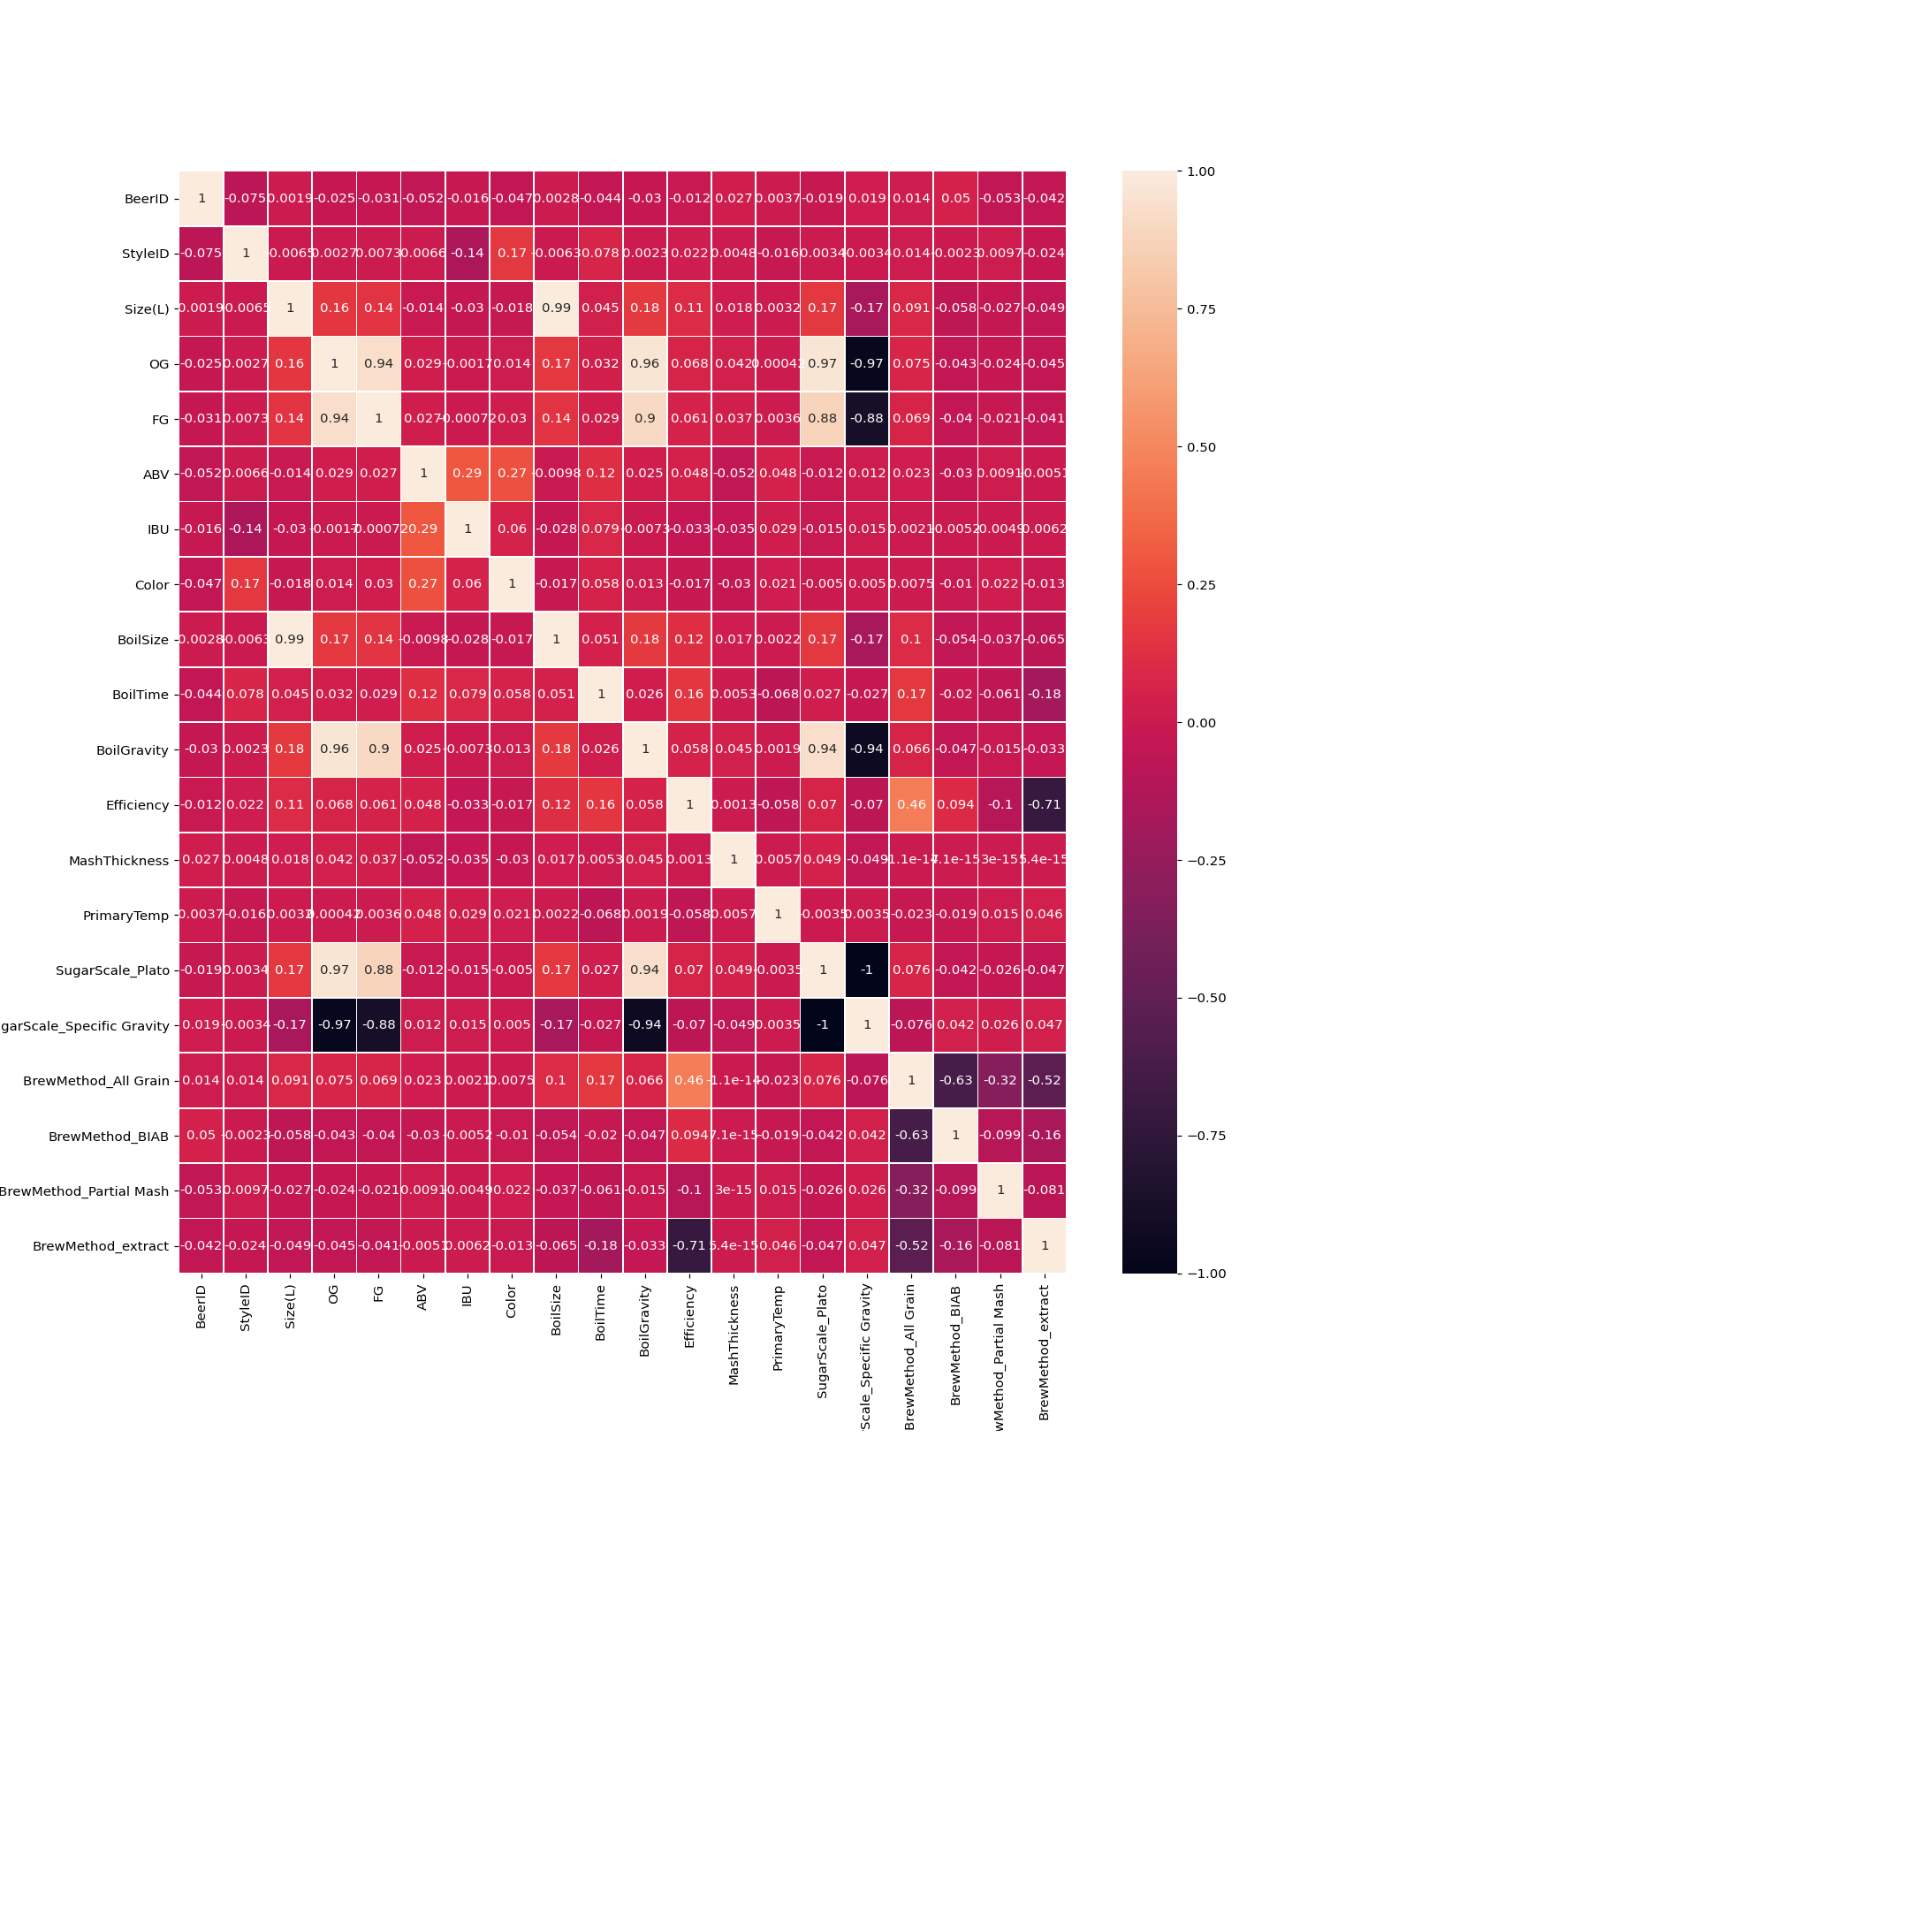

In [16]:
correlacio = df.corr()
plt.figure(figsize=(15, 15), dpi=80)
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Mirem com estàn distribuïdes i correlacionades entre elles. En general podem veure que estàn distribuïdes de manera molt desequil·librada.

<IPython.core.display.Javascript object>


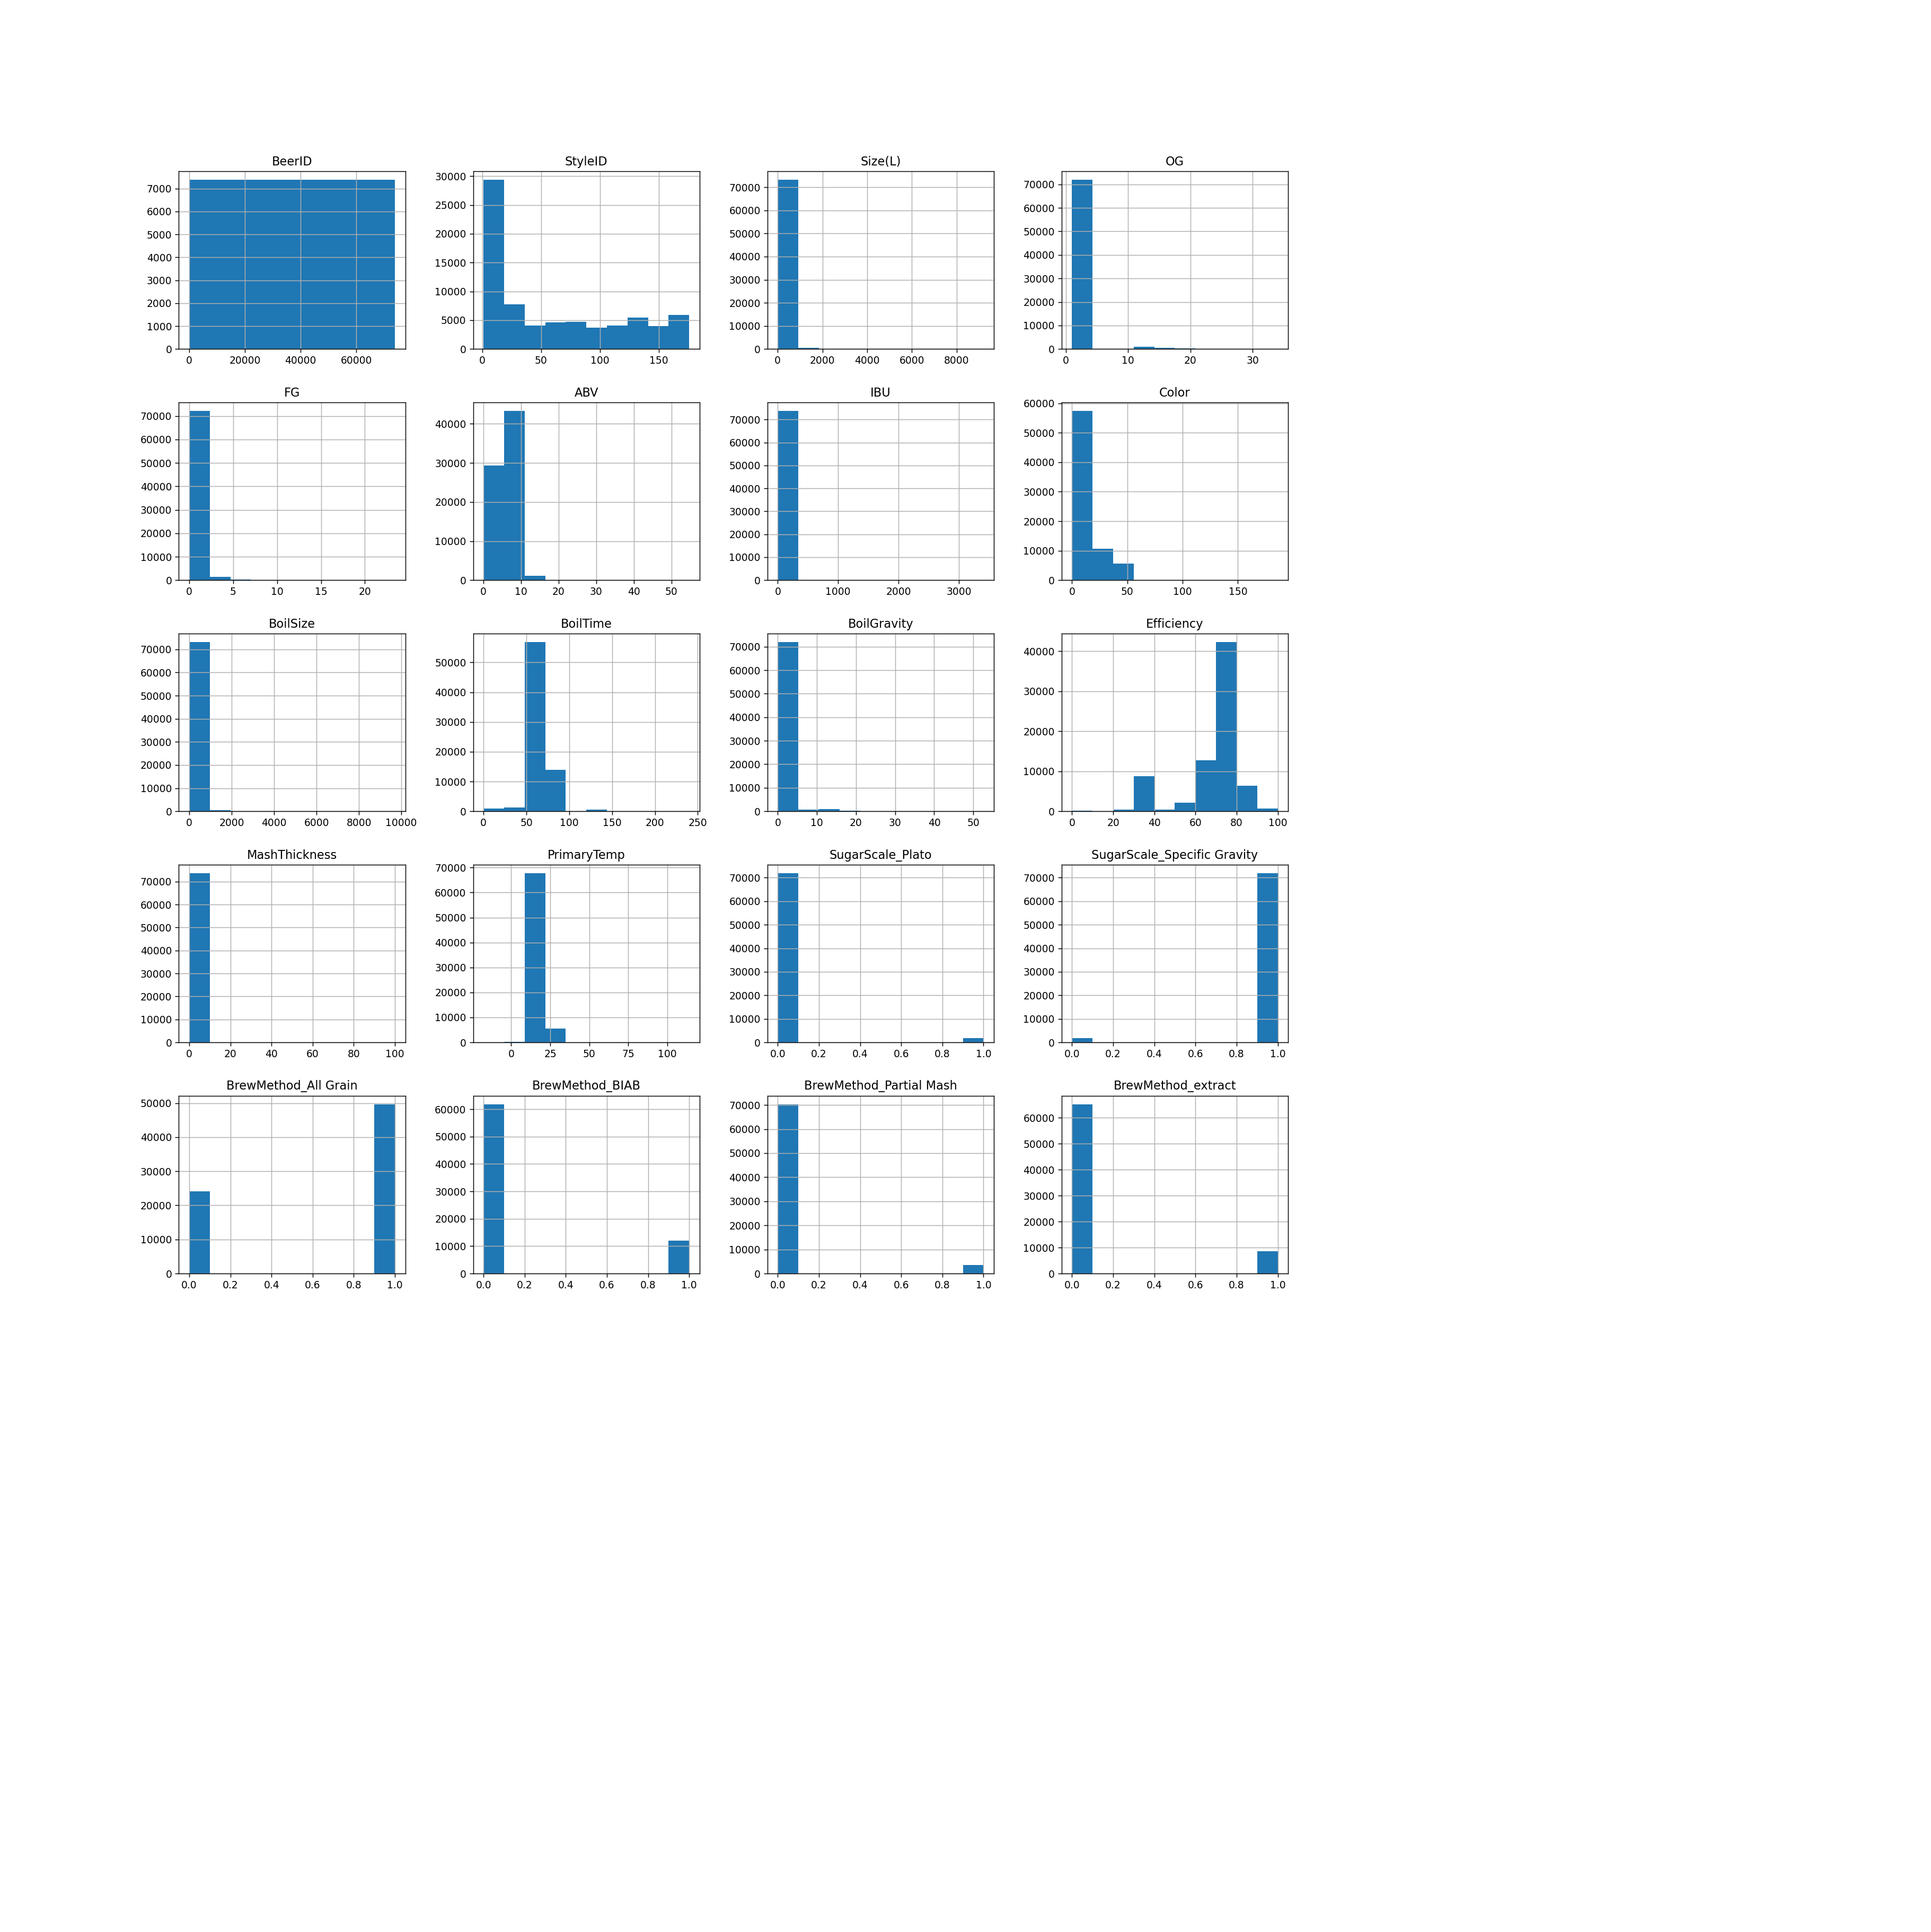

In [17]:
hist = df.hist(figsize=(20, 20))

**PREPROCESSING**

Veient les dades que tenim seria interessant intentar predir quin tipus d'elaboració de cervesa és segons les seves característiques. Hi ha molts estils de cerveses i la distribució de les dades està molt poc equil·librada.

In [43]:
len(df['StyleID'].unique())

176

In [60]:
types = 20
most_common = df['Style'].value_counts()[:types]
most_common

American IPA              11940
American Pale Ale          7581
Saison                     2617
American Light Lager       2277
American Amber Ale         2038
Blonde Ale                 1753
Imperial IPA               1478
American Stout             1268
Irish Red Ale              1204
American Brown Ale         1152
Witbier                    1072
California Common Beer     1044
Weissbier                   988
Oatmeal Stout               961
Russian Imperial Stout      929
Weizen/Weissbier            919
Sweet Stout                 919
Robust Porter               897
Kölsch                      869
Double IPA                  864
Name: Style, dtype: int64

<IPython.core.display.Javascript object>


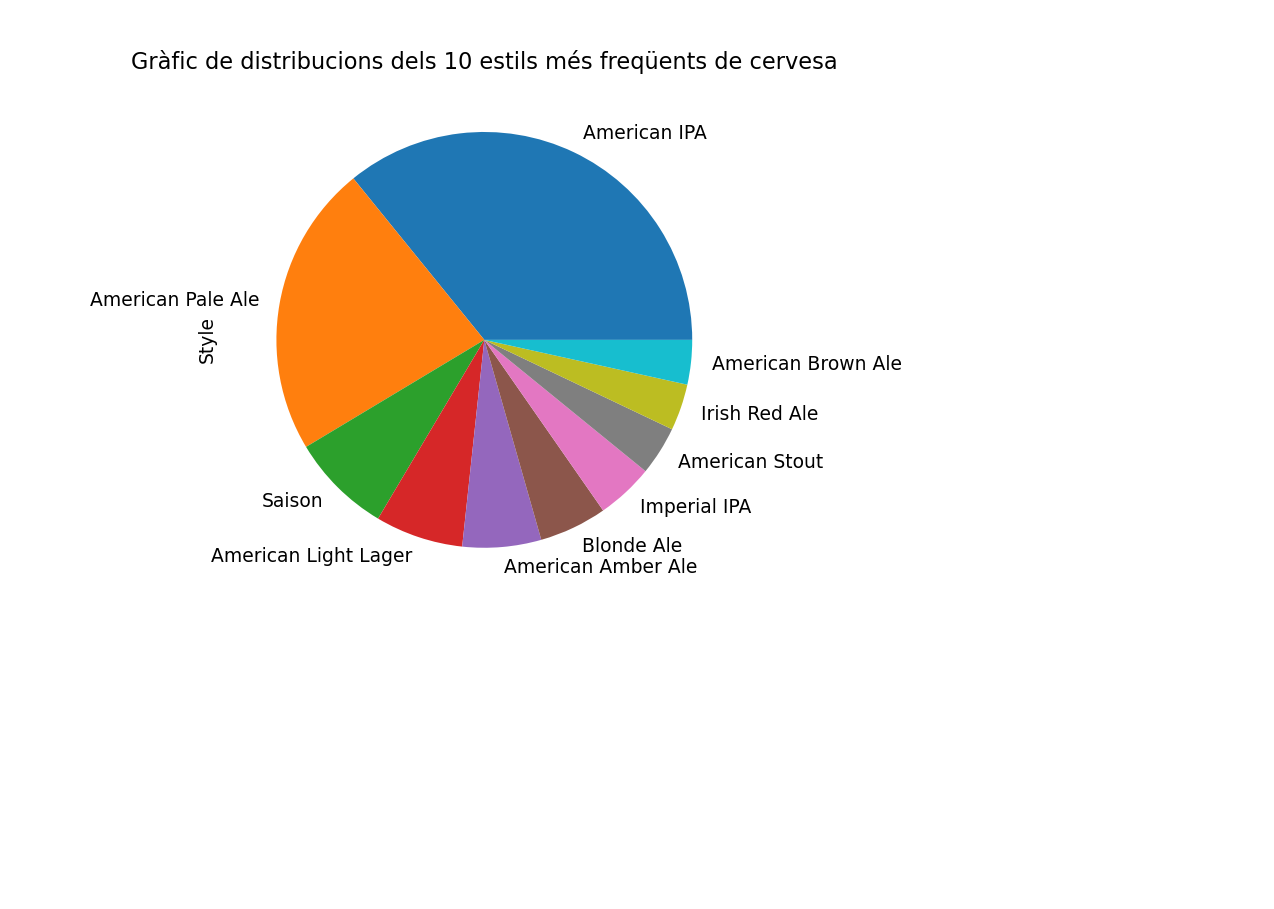

<AxesSubplot:title={'center':'Gràfic de distribucions dels 10 estils més freqüents de cervesa'}, ylabel='Style'>

In [58]:
dataset['Style'].value_counts()[:10].plot(kind='pie', figsize=(7,5), title='Gràfic de distribucions dels 10 estils més freqüents de cervesa')

Es pot veure com moltes de les classes són molt específiques. Per tal de reduir el número de classes a predir podem generalitzar les que són més comunes i agrupar les que quedin en una classe a part anomenada 'Other'. Un cop creat aquest nou atribut d'estils més general 'GeneralStyle', crearem un nou atribut 'GeneralStyleID' que segueixi aquest nou atribut per tal de poder-lo modelitzar.

In [20]:
general_styles = ['Ale', 'IPA', 'Pale Ale', 'Lager', 'Stout', 'Bitter', 'Cider', 'Porter']
df['GeneralStyle'] = 'Other'
for general_style in general_styles:
    df.loc[df['Style'].str.contains(general_style), 'GeneralStyle'] = general_style
df['GeneralStyle']

0          Ale
1        Other
2          IPA
3          IPA
4          Ale
         ...  
73856      Ale
73857      IPA
73858    Other
73859      Ale
73860      IPA
Name: GeneralStyle, Length: 73861, dtype: object

In [21]:
le = LabelEncoder()
le.fit(df.GeneralStyle)
df['GeneralStyleID'] = le.transform(df.GeneralStyle)

Fent aquest canvi ja podem veure que les correlacions són més altes que amb l'atribut 'StyleID'.

In [22]:
columns=df.columns
correlations_targ = df.corr()['GeneralStyleID'].abs().sort_values(ascending=False)
correlations_targ

GeneralStyleID                 1.000000
Color                          0.350645
StyleID                        0.199478
IBU                            0.040227
ABV                            0.039194
PrimaryTemp                    0.026477
FG                             0.018307
BoilTime                       0.013507
BoilGravity                    0.013351
OG                             0.012295
SugarScale_Specific Gravity    0.009179
SugarScale_Plato               0.009179
BrewMethod_Partial Mash        0.008257
BrewMethod_BIAB                0.007876
BrewMethod_All Grain           0.007702
BoilSize                       0.005055
Size(L)                        0.004941
MashThickness                  0.004711
BeerID                         0.004207
BrewMethod_extract             0.003281
Efficiency                     0.000118
Name: GeneralStyleID, dtype: float64

<IPython.core.display.Javascript object>


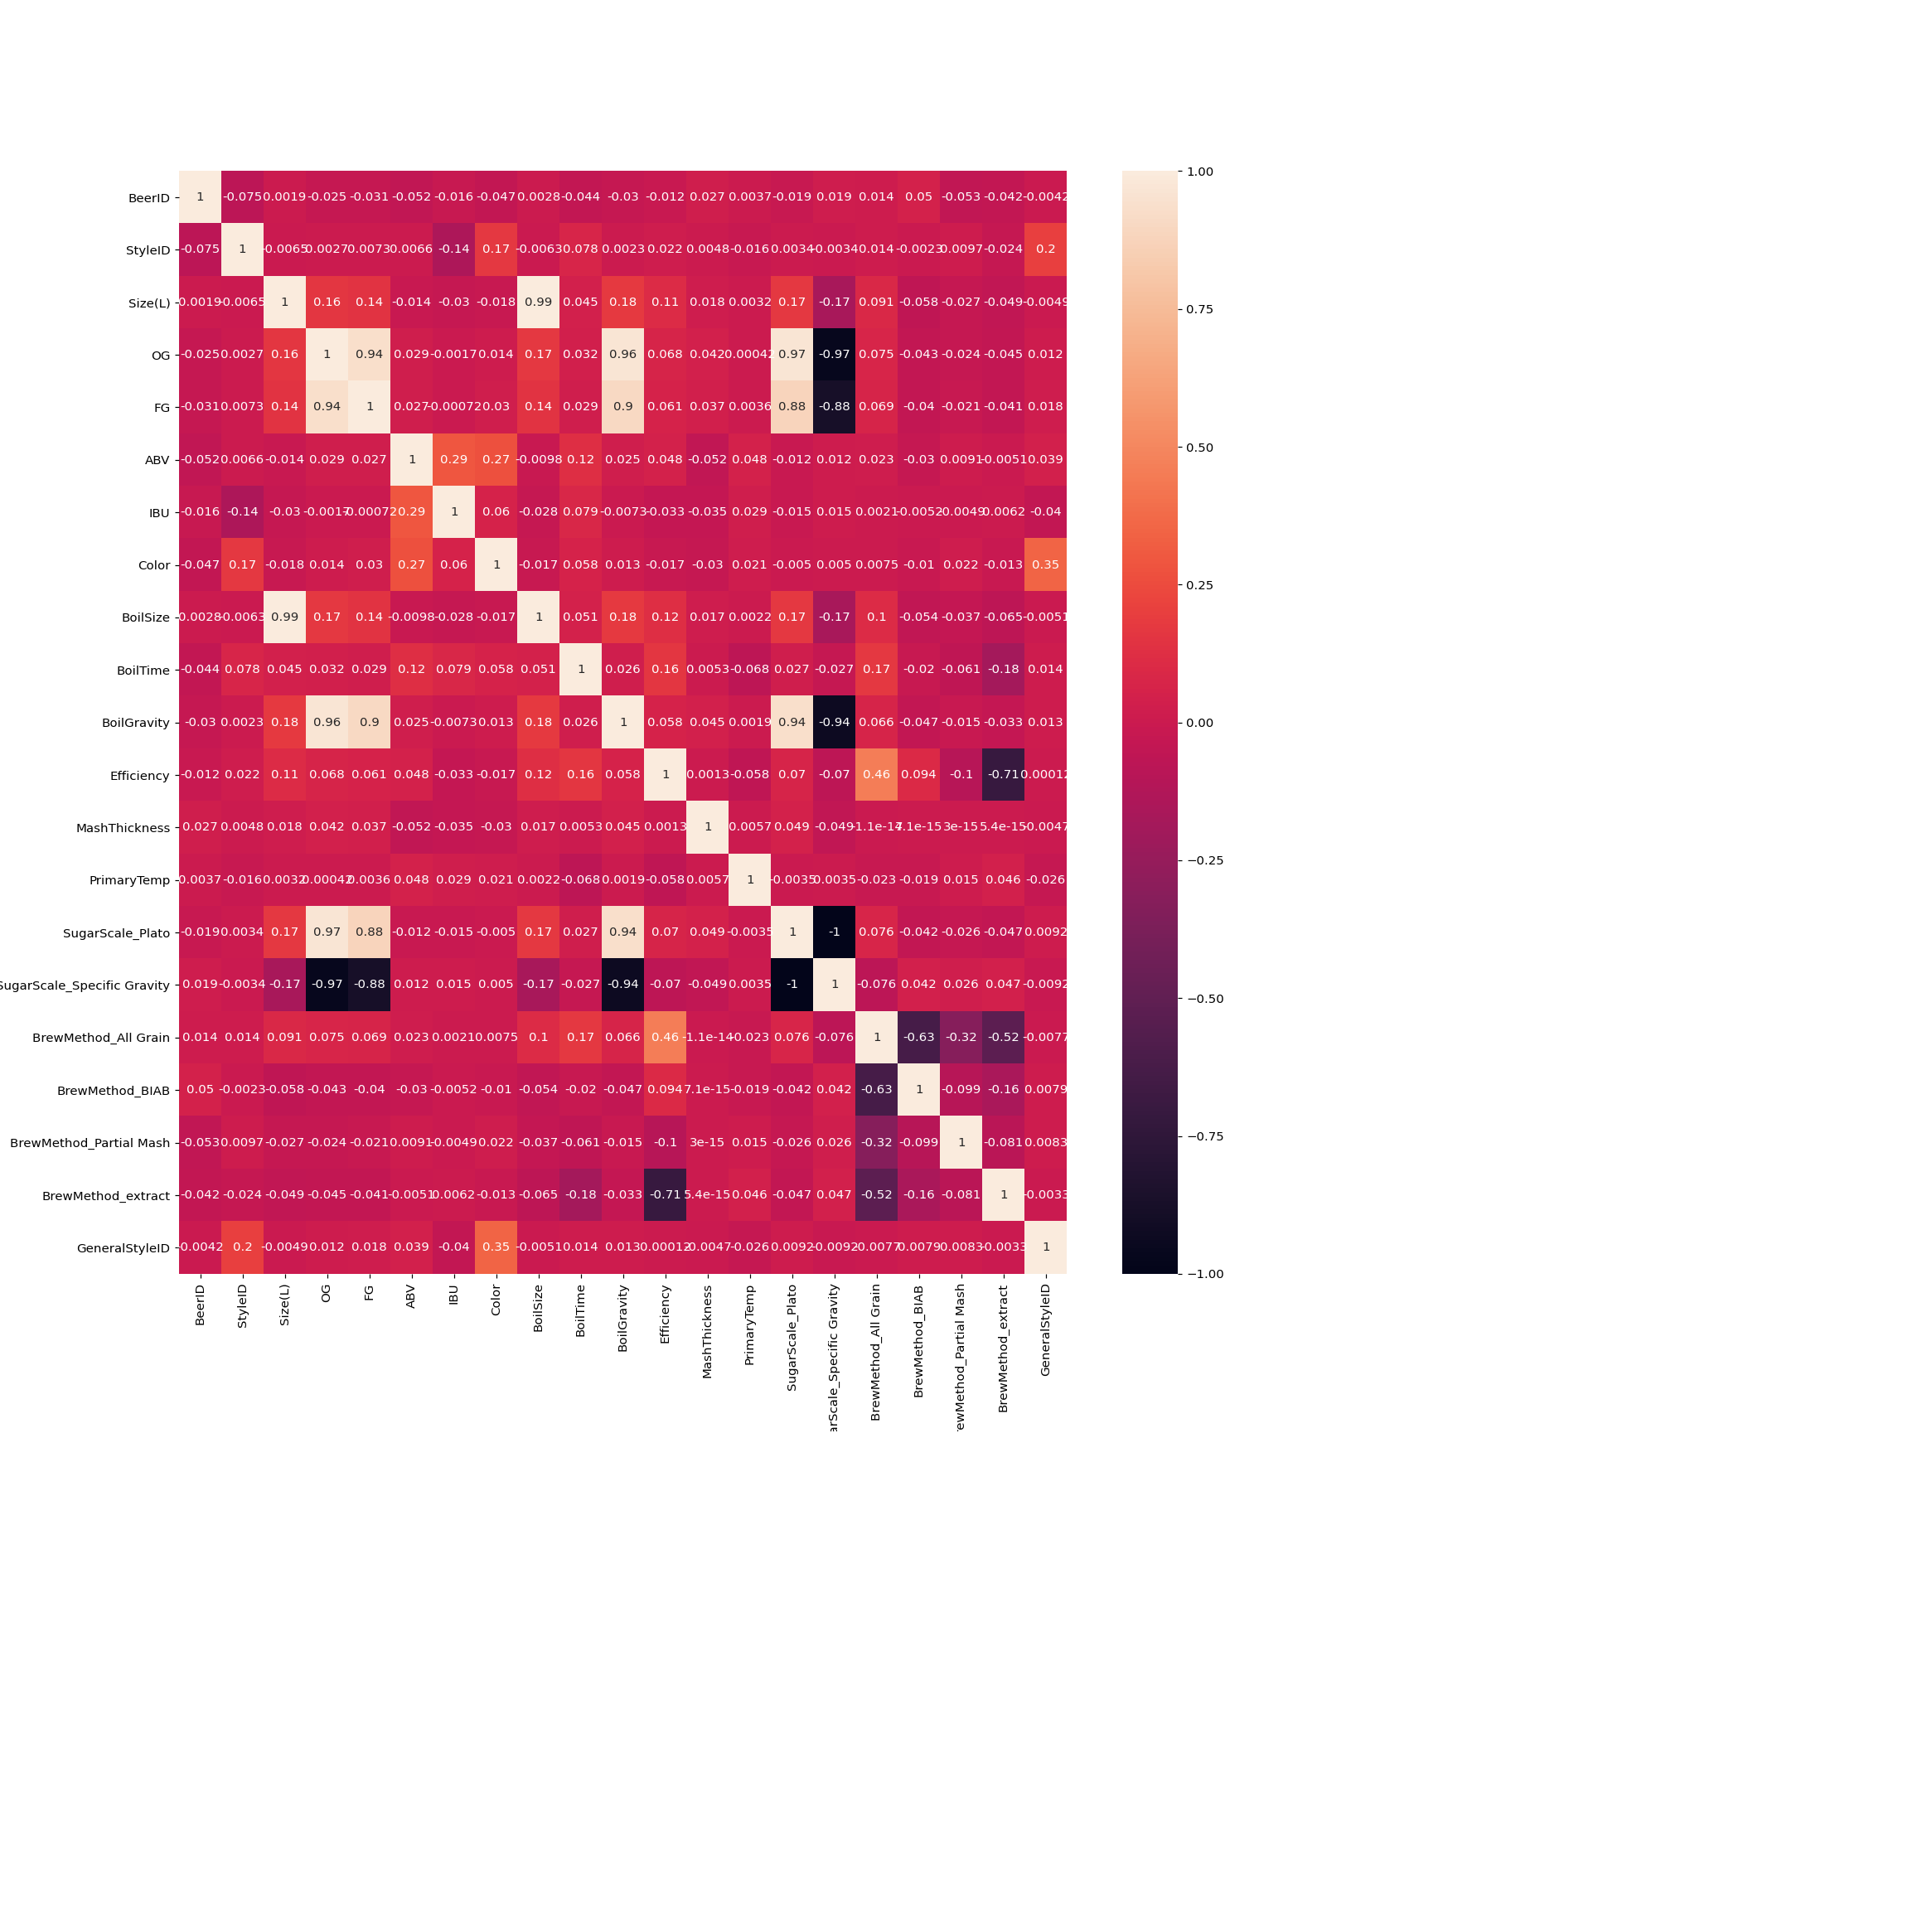

<AxesSubplot:>

In [23]:
plt.figure(figsize=(16, 16), dpi=80)
sns.heatmap(df.corr(), annot=True)

A continuació mirem si les dades estan normalitzades.

In [24]:
for col in df.select_dtypes(exclude='object'):
    _, pvalue = scipy.stats.normaltest(df[col])
    if pvalue > 1e-3:
        print(col)

Podem comprovar que les nostres dades no estàn normalitzades i a més estàn a escales molt diferents. Com que tenim molts atributs categòrics no ens surt a compte normalitzar i per tant només escalarem les dades utilitzant la funció *MinMaxScaler*, que fa que les dades estiguin a un rang entre 0 i 1.

Durant el meu estudi vaig provar d'utilitzar un dataset normalitzat també però em vaig trobar amb que tenia mals resultats i un cost de temps molt alt.

Per tal de poder seguir amb el nostre estudi eliminem les dades que són de tipus *object*.

In [25]:
generalstyle_names=df['GeneralStyle']
df=df.drop(['Style', 'GeneralStyle'],axis=1)

**MODEL SELECTION**

Per tal de poder trobar un bon model provem diferents tipus de classificadors que hem treballat durant el curs amb dues versions del dataset tractat, la primera com a original i la segona amb les dades escalades. Fem servir com a atribut objectiu 'Style' i 'GeneralStyle' per tal de poder comparar els resultats i veure si la estratègia escollida, generalitzant els tipus de cervesa, era adequada.

In [27]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB(),
    'RandomForest': RandomForestClassifier(n_estimators=10)
}

Preparem les dades utilitzant com a atribut objectiu 'Style':

In [31]:
TARGET='StyleID'
y=df[TARGET]
X=df.drop(columns=TARGET)
X_esc=X.copy(deep=True)
X_esc = pd.DataFrame(
    MinMaxScaler().fit_transform(X),
    columns=X_esc.columns
)
X_norm=X.copy(deep=True)
X_norm = pd.DataFrame(
    Normalizer().fit(X_norm).transform(X_norm),  
    columns=X_norm.columns
)

Xs = {
    'original': X,
    'escalat': X_esc,
    #'normalitzat': X_norm
}

In [32]:
scores_ls = []
confusion_matrix_ls = []
for tipus_df, X_df in Xs.items():
    #print(tipus_df)
    scores = {name: [] for name in classifiers}
    cms = {name: [] for name in classifiers}
    #for it in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2)
    for name, clf in classifiers.items():
        #print(name)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        #print(score)
        scores[name]=score

        #if it == 1:
        cm = confusion_matrix(y_test, y_pred)
        cms[name] = cm.ravel()
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#         disp.plot()
#         plt.title(f'Matriu de confusió amb el classificador {name}')
#         plt.show()

    
    scores = {name: score for name, score in scores.items()}
    scores_ls.append(scores)
    confusion_matrix_ls.append(cms)

pd.DataFrame(scores_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
LogisticRegression,0.214175,0.396467
SGDClassifier,0.046233,0.273878
KNeighborsClassifier,0.176741,0.469573
DecisionTreeClassifier,0.470385,0.468964
GaussianNB,0.230217,0.251946
RandomForest,0.541461,0.540378


El dataset amb les dades escalades ens dona millors resultats però podem veure que en general tenim uns valors molt baixos. El model que ens dona millors resultats en ambdós casos és el *Random Forest*. A més, tenen un cost de temps molt alt, això pot ser degut a que la nostra base de dades és molt gran.

Preparem les dades utilitzant com a atribut objectiu 'GeneralStyle':

In [28]:
TARGET='GeneralStyleID'
y=df[TARGET]
X=df.drop(columns=TARGET)
X_esc=X.copy(deep=True)
X_esc = pd.DataFrame(
    MinMaxScaler().fit_transform(X),
    columns=X_esc.columns
)
X_norm=X.copy(deep=True)
X_norm = pd.DataFrame(
    Normalizer().fit(X_norm).transform(X_norm),  
    columns=X_norm.columns
)

Xs = {
    'original': X,
    'escalat': X_esc,
    #'normalitzat': X_norm
}

In [29]:
scores_ls = []
confusion_matrix_ls = []
for tipus_df, X_df in Xs.items():
    scores = {name: [] for name in classifiers}
    cms = {name: [] for name in classifiers}
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2)
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        scores[name]=score
        cm = confusion_matrix(y_test, y_pred)
        cms[name] = cm.ravel()
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#         disp.plot()
#         plt.title(f'Matriu de confusió amb el classificador {name}')
#         plt.show()

    
    scores = {name: score for name, score in scores.items()}
    scores_ls.append(scores)
    confusion_matrix_ls.append(cms)

pd.DataFrame(scores_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
LogisticRegression,0.558857,0.553916
SGDClassifier,0.339538,0.409734
KNeighborsClassifier,0.449198,0.698166
DecisionTreeClassifier,0.993299,0.992419
GaussianNB,0.376701,0.378055
RandomForest,0.896703,0.880661


En aquest cas, a primera instància veiem que no hi ha molta diferència entre el dataset original i amb les dades escalades, tot i que en general el escalat ens dona millors resultats. Veiem que el millor model en amdós casos seria el *Decision Tree Classifier* ja que ens dona una precisió del 99%, un molt bon resultat. Tot i que també tenen un cost de temps alt degut a les dimensions de la nostra base de dades, no és tant alt com en el cas d'utilitzar com a atribut objectiu 'Style'.

**HYPER PARAMETER SEARCH**

Per tal de poder trobar els millors paràmetres pels models que ens han donat més bons resultats utilitzem la funció *RandomizedSearchCV* ja que no té un cost computacional tant alt en comparació amb altres funcions que ens permeten trobar els millors paràmetres. Utilitzem com a atribut objectiu 'GeneralStyle'.

Primerament busquem els millors paràmetres pel *Regressor Logístic*.

In [95]:
params_ls=[]
for _ , X_df in Xs.items():
    logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
    distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])
    clf = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=5)
    search = clf.fit(X_df, y)
    best=search.best_params_
    params = {name: param for name, param in best.items()}
    params_ls.append(params)
pd.DataFrame(params_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
C,2.195254,2.179533
penalty,l1,l1


A continuació busquem els millors paràmetres pel *Decision Tree Classifier*.

In [89]:
params_ls=[]
for _ , X_df in Xs.items():
    DT =tree.DecisionTreeClassifier()
    distributions = dict(criterion=['gini', 'entropy'])
    clf = RandomizedSearchCV(DT, distributions, random_state=0, n_iter=2)
    search = clf.fit(X_df, y)
    best=search.best_params_
    params = {name: param for name, param in best.items()}
    params_ls.append(params)
pd.DataFrame(params_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
criterion,entropy,entropy


Finalment, busquem els millors paràmetres pel *Random Forest*.

In [94]:
params_ls=[]
for _ , X_df in Xs.items():
    RF =RandomForestClassifier()
    distributions = dict(n_estimators=[10, 50, 100], min_samples_leaf=[1, 2, 3])
    clf = RandomizedSearchCV(RF, distributions, random_state=0, n_iter=9)
    search = clf.fit(X_df, y)
    best=search.best_params_
    params = {name: param for name, param in best.items()}
    params_ls.append(params)
pd.DataFrame(params_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
n_estimators,100,50
min_samples_leaf,1,2


**CROSS-VALIDATION**

A continuació, farem la cross validació dels nostres models utilitzant com a atribut objectiu 'GeneralStyle'.

In [30]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
metrics = ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
data = []

for name_df , X_df in Xs.items():
    scores = []
    #print(name_df)
    for name, clf in classifiers.items():
        #print(name)
        cv = cross_validate(clf, X_df, y, scoring=scoring, cv=5)
        cv = [ls.mean() for metric, ls in cv.items()]
        scores.append(cv)
    data.append(scores)

data = np.array(data)
# for i, metric in enumerate(metrics):
#     pd.DataFrame(
#         np.array([data[0, :, i], data[1, :, i]]).transpose(),
#         columns=['Original', 'Escalat'],
#         index=classifiers.keys()
#     ).plot.barh()
#     plt.title(metric)
#     plt.xlabel('metric')
for i, metric in enumerate(metrics):
    results=pd.DataFrame(
        np.array([data[0, :, i], data[1, :, i]]).transpose(),
        columns=['Original', 'Escalat'],
        index=classifiers.keys()
    )
    print(metric)
    print(results)
    print("\n")

fit_time
                          Original    Escalat
LogisticRegression      196.507211  26.919249
SGDClassifier            26.026063   0.660255
KNeighborsClassifier      0.020153   0.016355
DecisionTreeClassifier    0.508262   0.484116
GaussianNB                0.045286   0.040909
RandomForest              1.304013   1.180053


score_time
                         Original    Escalat
LogisticRegression       0.025533   0.021941
SGDClassifier            0.023129   0.019335
KNeighborsClassifier    21.023236  18.975919
DecisionTreeClassifier   0.025729   0.021342
GaussianNB               0.049861   0.045870
RandomForest             0.071017   0.058238


test_precision_macro
                        Original   Escalat
LogisticRegression      0.344055  0.397862
SGDClassifier           0.254830  0.091439
KNeighborsClassifier    0.015531  0.419873
DecisionTreeClassifier  0.932685  0.928897
GaussianNB              0.378811  0.375206
RandomForest            0.795192  0.789091


test_recall_mac

Podem veure els gràfics que ens surten quan executem el codi anterior:

<table><tr><td><img src='grafic1cv.png'></td><td><img src='grafic3cv.png'></td></tr></table>

<table><tr><td><img src='grafic2cv.png'></td><td><img src='grafic4cv.png'></td></tr></table>

<table><tr><td><img src='grafic5cv.png'></td></tr></table>

Veient els resultats obtinguts podem veure com clarament el millor model és el *Decision Tree Classifier* amb el dataset amb les dades escalades. No només dona millors resultats sinó que també té un temps d'execució molt més baix que els altres models. El segon model amb millors resultats és el *Random Forest*, però és més costós en temps i no arriba a tenir tant bons resultats.

També podem veure com el model més costós en temps és clarament el *Regressor Logístic* arribant gairebé als 200 segons amb el dataset sense les dades escalades.

**CONCLUSIONS**

Després d'haver fet tot l'estudi de les nostres dades podem extreure'n algunes conclusions.

Hem pogut veure que per crear el nostre model és millor utilitzar com a atribut objectiu 'GeneralStyle', atribut creat amb nou classes on hem generalitzat els estils de cervesa existents; ja que dona millors resultats i a més té un temps d'execució més baix que no pas utilitzant l'atribut ja existent 'Style'.

Quan hem estudiat inicialment els possibles models per tal de classificar per classes les nostres dades hem vist que el que donava millors resultats era el *Decision Tree Classifier* amb el dataset de les dades no escalades, tot i que la diferència entre els dos datasets treballats era molt petita.

Un cop trobats els resultats dels models hem buscat els millors paràmetres pels tres millors utilitzant com a atribut objectiu 'GeneralStyle'. Pel dataset amb les dades sense escalar hem vist que els millors paràmetres pel *Regressor Logístic* són un valor de *C* de 2.195254 i un regularitzador *l1*. Pel *Decision Tree Classifier* utilitzant el criteri de *entropy*. I finalment, pel *Random Forest* utilitzant 100 arbres i un nombre mínim de mostres necessàries per dividir un node intern de 1. En el cas del dataset amb les dades escalades hem vist que els millors paràmetres pel *Regressor Logístic* són un valor de *C* de 2.179533 i un regularitzador *l1*. Pel *Decision Tree Classifier* utilitzant el criteri de *entropy*. I finalment, pel *Random Forest* utilitzant 50 arbres i un nombre mínim de mostres necessàries per dividir un node intern de 2.

Finalment, hem fet una cross-validació dels nostres models amb l'atribut objectiu 'GeneralStyle'. Hem pogut veure com efectivament, el model *Decision Tree Classifier* ens dona els millors resultats amb un temps d'execució molt bo en comparació amb els altres models. A més, hem vist que el dataset amb les dades escalades ens dona millors resultats i té un cost de temps més baix.